# Fundamentals of Probabilistic Data Mining
Authors: Carolina Guerra, Nurtay Zhumazhanov, Larry Goyeau, Rebecca Bauer
## 1 Mixture Models

In [74]:
# setup
import numpy as np
import matplotlib.pyplot as plt # plots
from PIL import Image # load image
from numpy import loadtxt # load .txt document
import glob # load all files in file
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import multivariate_normal as multi
from matplotlib.colors import LogNorm
from sklearn import mixture # gmm
from numpy import linalg # check for singular matrix
import sys

import csv
from matplotlib.colors import LogNorm
from scipy.special import iv
from scipy.optimize import fsolve

For some plots we want to have our own colors, so we set them:

In [75]:
# set colors, cannot have more than 5 clusters
col = ['dodgerblue','deeppink','g','b','r']

### helper functions

We put some helper functions here, so that the code below can be read more easily. We mainly have helper functions for plotting and setting parameters.

#### Plotting 2D diagram with log(pdf)

In [101]:
# plot log(pdf)
def plot_data(values, labels, gmm):
    # meshgrid
    x = np.linspace(-1.5,1.5)
    y = np.linspace(-1.5,1.5)
    X, Y = np.meshgrid(x,y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    # plot contour
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
                    
    plt.scatter(values[:, 0], values[:, 1],.8, c=labels)
    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()

def plot_data_A(values, labels, gmm):
    # meshgrid
    X, Y = np.meshgrid( np.linspace(0,max(values[0])+30),np.linspace(0,max(values[1])))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    # plot contour
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                     levels=np.logspace(0, 4, 15))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(values[:, 0], values[:, 1],.8, c=labels)
    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()

#### Plotting histograms and pdfs

In [77]:
kwargs = dict(alpha = 0.5, linewidth = 2, bins = 30, density = True)

# Gaussian pdf
def gmm_pdf(gmm,label,color,dim):
    mu = np.round(gmm.means_,2)[label,dim]
    variance = np.round(gmm.covariances_,2)[label][dim,dim]
    sigma = variance**(1/2)
    x_density = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x_density, stats.norm.pdf(x_density, mu, sigma), 
             color = color, label = 'pdf' + str(label+1))
    
# pdf x and y
def pdf_x(gmm,label,color):
    gmm_pdf(gmm,label,color,0)

def pdf_y(gmm,label,color):
    gmm_pdf(gmm,label,color,1)
    
# plot configuration    
def plot_config_all(axis):
    plt.gca().set(title='Histogram of the ' + str(k) + ' clusters distributions for axis ' + axis)
    plt.gca().axes.set_ylim([0,5])
    plt.legend()
    
def plot_config(cluster, axis):
    plt.gca().set(title='Histogram of cluster ' + str(cluster) + ' for axis' + axis)
    plt.gca().axes.set_ylim([0,5])
    plt.legend()
    
# plot single histogram + pdf
def plot_single(label,axis):
    color = col[label]
    # plot histogram + pdf
    if (axis == 'x'):
        plt.hist(x[labels == label], label = 'cluster' + str(label+1), **kwargs, color = color)
        pdf_x(gmm, label = label, color = color)
    else:
        plt.hist(y[labels == label], label = 'cluster' + str(label+1), **kwargs, color = color)
        pdf_y(gmm, label = label, color = color)
    plot_config(cluster = label+1, axis = axis)
    plt.show()

#### Von Mises pdf

Source: https://framagit.org/fraschelle/mixture-of-von-mises-distributions

In [78]:
def vonmises_density(x,mu,kappa):
    """
    Calculate the von Mises density for a series x (a 1D numpy.array).
    Input : 
        x : a 1D numpy.array of size L
        mu : a 1D numpy.array of size n, the mean of the von Mises distributions
        kappa : a 1D numpy.array of size n, the dispersion of the von Mises distributions
    Output : 
        a (L x n) numpy array, L is the length of the series, and n is the size of the array containing the parameters. Each row of the output corresponds to a density
    """
    res = []
    for i in x:
        f = np.exp(kappa*np.cos(i-mu))
        n = 2*np.pi*iv(0,kappa)
        res.append(f/n)
    return(np.array(res))


def mixture_vonmises_pdfit(series, n=2, threshold=1e-3):
    """
    Find the parameters of a mixture of von Mises distributions, using an EM algorithm.
    Input : 
        series : a 1D numpy array, representing the stochastic perdioci process
        n : an int, the number of von Mises distributions in th emixture
        threshold : a float, correspond to the euclidean distance between the old parameters and the new ones
    Output : a (3 x n) numpy-array, containing the probability amplitude of the distribution, and the mu and kappa parameters on each line.
    """
    # initialise the parameters and the distributions
    pi = np.random.random(n)
    mu = np.random.vonmises(0.0,0.0,n)
    kappa = np.random.random(n)
    t = pi*vonmises_density(series,mu,kappa)
    s = np.sum(t, axis=1)
    t = (t.T/s).T
    thresh = 1.0
    # calculate and update the coefficients, untill convergence
    while thresh > threshold:
        new_pi = np.mean(t, axis=0)
        new_mu = np.arctan2(np.sin(series)@t,np.cos(series)@t)      
        c = np.cos(series)@(t*np.cos(new_mu))+np.sin(series)@(t*np.sin(new_mu))
        k = lambda kappa: (c-iv(1,kappa)/iv(0,kappa)*np.sum(t, axis=0)).reshape(n)
        new_kappa = fsolve(k, np.zeros(n))
        thresh = np.sum((pi-new_pi)**2+(mu-new_mu)**2+(kappa-new_kappa)**2)
        pi = new_pi
        mu = new_mu
        kappa = new_kappa
        t = pi*vonmises_density(series,mu,kappa)
        s = np.sum(t, axis=1)
        t = (t.T/s).T
    res = np.array([pi,mu,kappa])
    # in case there is no mixture, one fits the data using the estimators
    if n == 1:
        res = vonmises_pdfit(series)
        res = np.append(1.0,res)
        res = res.reshape(3,1)
    return(res)

## 1.1.1 Preparatory work and modelling

### 1.1.1 (1.) Derive de reestimation formula for Gaussian Mixture Model (GMM)

Let $\Theta = (\pi_1,..., \pi_k,\theta_1,..., \theta_k)$, then $p_{\Theta}= \sum_{k=1}^K \pi_k p_{\theta_k}$

Following the EM algorithm, the goal is to find the parameters $\Theta^{(t+1)} $, that maximize $Q(\theta, \theta^{(t)}) =$ E$[ \log \rho_{\Theta}((x))]$

By Baes theorem we compute $ p(Z|x_n,\theta^{(i)})$
$$P(Z_n = k | x_n, \theta^{(i)}) = \frac{p(x_n | Z_n=k)p(Z_n=k | \theta^{(i)})}{p_{\theta^{(i)}}(x_n)} = \frac{p_{\theta_k}(x_n) \pi_k}{p_{\theta^{(i)}}(x_n)} = \frac{\mathcal{N}(\mu_k, \Sigma_k)\pi_k}{\sum_k \pi_k \mathcal{N}(\mu_k, \Sigma_k)}$$

Note that the Guassian distribution as a pdf $\mathcal{N}(\mu_k, \pi_k) = (2\pi)^{-K/2} |\Sigma|^{-1/2} \exp (-1/2 (x-\mu)^T \Sigma^{-1} (x-\mu))$

Hence,

$$Q(\theta, \theta^{(t)}) = E\left[\log \rho_{\Theta}(x)] = E[\log \prod_{n=1}^N \rho_{\theta}(x)\right] = $$
$$    = E\left[\log \sum_{n=1}^N \sum_{k=1}^K \pi_k \rho_{\theta_k}(x_n)\right] = $$
$$    = E\left[\log \prod_{n=1}^N \sum_{k=1}^K 1_{(Z_n=k)} \pi_k \rho_{\theta_k}(x_n) \right] = $$
$$    = E\left[ \log \prod_{n=1}^N \prod_{k=1}^K \pi_k^{1_{(Z_n = k)}} \rho_{\theta_k}(x_n)\right] = $$
$$    = E\left[ \log \sum_{n=1}^N \sum_{k=1}^K 1_{(Z_n=k)} \left( \log(\pi_k) + \log(\mathcal{N}(\mu_k,\Sigma_k)) \right) \right] = $$
$$ = E \left[ \sum_{n=1}^N \sum_{k=1}^K 1_{(Z_n =k)} \left( \log (\pi_k) - \frac{K}{2} \log(2 \pi) - \frac{1}{2} \log(\Sigma_k) - \frac{1}{2}(x-\mu_k)^T \Sigma^{-1}(x-\mu_k) \right) \right] = $$
$$ = \sum_{n=1}^N \sum_{k=1}^K \left( P(Z_n=k | x_n, \theta^{(t)}) \left( \log (\pi_k) - \frac{K}{2} \log(2 \pi) - \frac{1}{2} \log(\Sigma_k) - \frac{1}{2}(x-\mu_k)^T \Sigma^{-1}(x-\mu_k) \right) \right)$$

Thus, the estimation $ \Theta ^{(t+1)}$ is given by the formula:

$$\text{argmax}_{\Theta} \sum_{n=1}^N \sum_{k=1}^K \left( P(Z_n=k | x_n, \theta^{(t)}) \left( \log (\pi_k) - \frac{K}{2} \log(2 \pi) - \frac{1}{2} \log(\Sigma_k) - \frac{1}{2}(x-\mu_k)^T \Sigma^{-1}(x-\mu_k) \right) \right) $$
a
where $P(Z_n=k | x_n, \theta^{(t)})$ is given by the expression calculated above.

Therefore, to estimate the mean and covariance of cluster $k$, i.e. to compute $(\mu_k^{(t+1)}, \Sigma_k^{(t+1)}) = \text{argmax}_{\mu_k,\Sigma_k} Q(\theta , \theta^{(t)})$ we find the zero of the derivative of $Q(\theta , \theta^{(t)})$ in order to $\mu_k$ and $\Sigma_k$ :

$$ \mu_k^{(t+1)} = \frac{\sum_{n=1}^N P(Z_n = k | x_n, \theta^{(t)})x_n}{\sum_{n=1}^N P(Z_n = k | x_n, \theta^{(t)})} $$

and

$$ \Sigma_k^{(t+1)} = \frac{\sum_{n=1}^N P(Z_n = k | x_n, \theta^{(t)}) (x_n-\mu_k^{(t+1)})(x_n-\mu_k^{(t+1)})^T}{\sum_{n=1}^N P(Z_n = k | x_n, \theta^{(t)})} $$




### 1.1.1 (2.) Simulate a sample of size 500 of the following bivariate GMM: 
$0.3\mathcal{N}(\mu_1;\sum_1) + 0.7\mathcal{N}(\mu_2;\sum_2)$,

$\mu_1 = \begin{pmatrix} -3 \\ 0 \end{pmatrix}, \mu_2 = \begin{pmatrix} 3 \\ 0 \end{pmatrix} and \sum_1 = \begin{pmatrix} 5 & -2 \\ -2 & 1 \end{pmatrix}, \sum_2 = \begin{pmatrix} 5 & 2 \\ 2 & 2 \end{pmatrix}$

We first define some parameters:

In [79]:
# parameter definition
mean1 = [-3, 0]
cov1  = [[5, -2], [-2, 1]]

mean2 = [3,0]
cov2  = [[5, 2], [2, 2]]

# Gauss distributions
gauss1 = np.random.multivariate_normal(mean1, cov1, int(0.3 * 500)).T
gauss2 = np.random.multivariate_normal(mean2, cov2, int(0.7 * 500)).T

Let us now plot the Gaussian distributions separately:

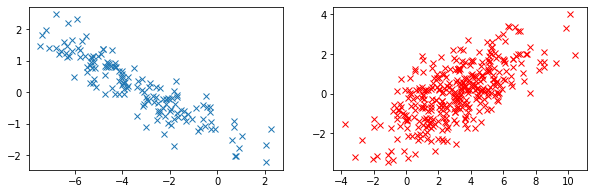

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# plot separately
axes[0].plot(gauss1[0], gauss1[1], 'x')
axes[1].plot(gauss2[0], gauss2[1], 'x', color = 'r')

plt.show()

### Plot the synthetic data set and check if it corresponds to the figures in the slides of the class

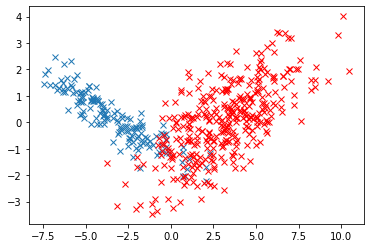

In [81]:
# plot together
plt.plot(gauss1[0], gauss1[1],'x')
plt.plot(gauss2[0], gauss2[1],'x', color = 'r')

plt.show()

These two distributions are fairly similar to the picture we had in class (see following).

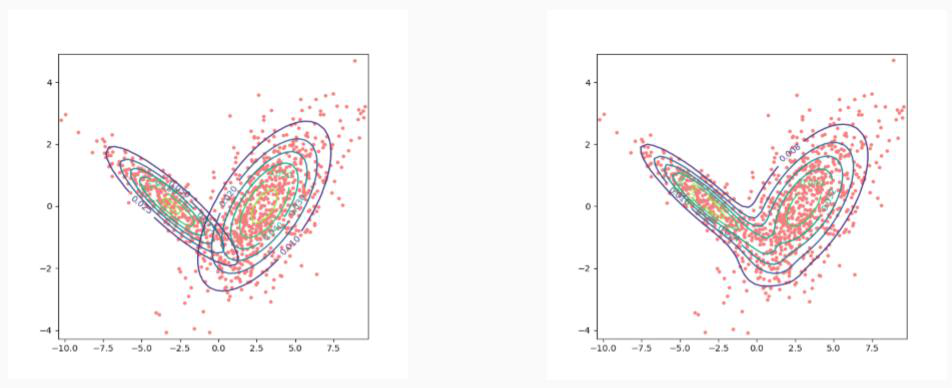

In [82]:
# load image from slides
Image.open("distributions.jpg")

### 1.1.1 (3.) Download (from chamilo), load and plot the Unistroke data set (letter A) and provide the figure.

We first load $amerge$:

In [83]:
# load data
data = loadtxt("data/Amerge.txt", delimiter=" ")

x = data[:,0]
y = data[:,1]

We now plot the dataset and see that all points (or rather vectors) are normalised, thus they lie on a circle with radius $1$. We can observe that there are about three clusters.

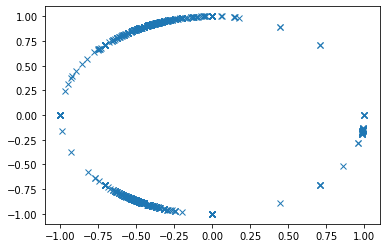

In [84]:
# plot
plt.plot(x,y,'x')
plt.show()

Then we load the $A$ files and concatenate them:

In [85]:
# plot all As
paths = glob.glob('data/A[0-9][0-9].txt') # regular expression
files = [loadtxt(f) for f in paths]

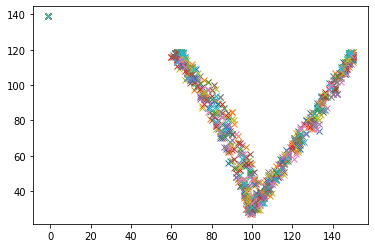

In [86]:
# plot
for file in files:
    plt.plot(file[:,0],file[:,1],'x')
    
plt.show()

As we can see there is one outlier. The dataset has a V shape and two clusters can be observed.

### 1.1.1 (4.) Do you think a 2-components GMM could be appropriate for letter A? Why?

As we can see in the amerge plot there are three areas with high density - two big ones and a small one. As we will see in the next exercises, the Gaussian pdfs are not stable for two clusters, only for three. For the $A$ sets however we have two clusters. These clusters do not need to be related however! Although one dataset is a transformation of the other.

## 1.1.2 Data analysis: Gaussian model

### 1.1.2 (1.) stimate a bivariate GMM on the letter A data set and provide the estimated parameters.

We first use $amerge$ to calculate the parameters and then compare them with the concatenated $A$ sets parameters. We take three components.

In [87]:
# components
k = 3

# gmm
gmm = mixture.GaussianMixture(n_components=k).fit(data)
labels = gmm.predict(data)

As we can see three clusters fit quite well!

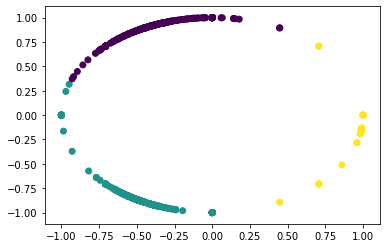

In [88]:
# plot
plt.scatter(x,y, c=labels)
plt.show()

Let us extract the parameters (weights of each cluster, the means and the covariance matrices since we are bivariate):

In [89]:
weights = gmm.weights_
means = gmm.means_
cov = gmm.covariances_

# print weights, means, coviariances
print('Weights: \n',np.round(weights,2), ',\n\n',
      'Means: \n',np.round(means,2), ',\n\n', 
      'Covariances: \n',np.round(cov,2))

Weights: 
 [0.48 0.45 0.07] ,

 Means: 
 [[-0.37  0.9 ]
 [-0.48 -0.83]
 [ 0.95 -0.17]] ,

 Covariances: 
 [[[ 0.04  0.02]
  [ 0.02  0.01]]

 [[ 0.03 -0.03]
  [-0.03  0.04]]

 [[ 0.01  0.01]
  [ 0.01  0.06]]]


In addition to $amerge$ we do the same with the $A$ data sets to compare the classification.

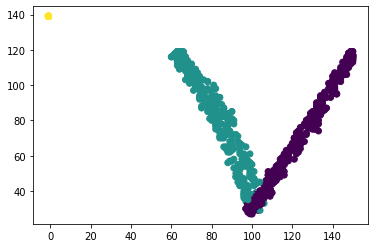

In [90]:
# concatenate As
data_A = np.concatenate(files)
data_A.size

x_A = data_A[:,0]
y_A = data_A[:,1]

# plot
gmm_A = mixture.GaussianMixture(n_components=k).fit(data_A)
labels_A = gmm_A.predict(data_A)
plt.scatter(x_A, y_A, c=labels_A)
plt.show()

In [91]:
# print weights, means, coviariances
print('Weights: \n', np.round(gmm_A.weights_,2))

Weights: 
 [0.49 0.46 0.05]


As we can see the classes weights are very similar. We cannot compare the means and variances, that would not make sense.

### 1.1.2 (2.) Label the data using the estimated model and show the pdf of the estimated GMM
Provide one figure with the data labeled in color overlapping on the contours of the log(pdf), please add inline labels for the contours).

We choose the $amerge$ set and make several trials to test on consistency. With only two components the model was not consistent since the curves varied a lot. Changing the number of clusters temporally to 2 or even 4 we can see the instability.

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]


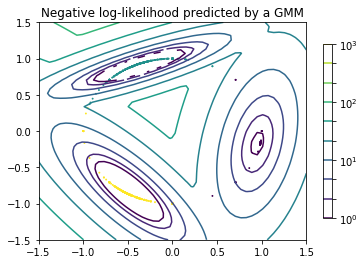

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]


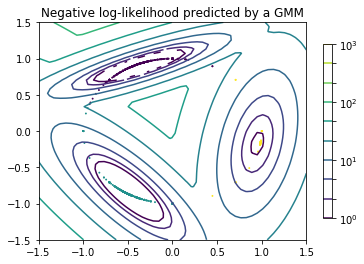

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]


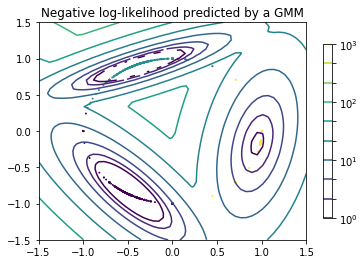

In [102]:
trials = 3 # for comparison
k_temp = 3

# plot
for i in range(trials):
    
    # fit new gmm
    gmm_temp = mixture.GaussianMixture(n_components=k_temp).fit(data)
    labels_temp = gmm_temp.predict(data)
    
    plot_data(data, labels_temp, gmm_temp)
    
plt.show()

We can do the same thing for the $A$ set:

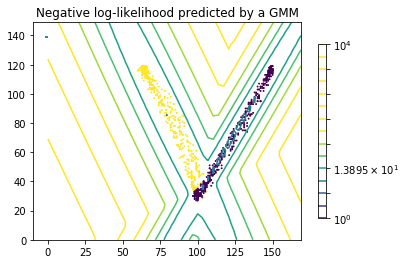

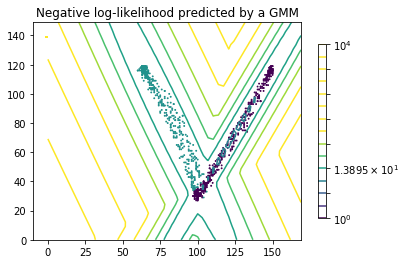

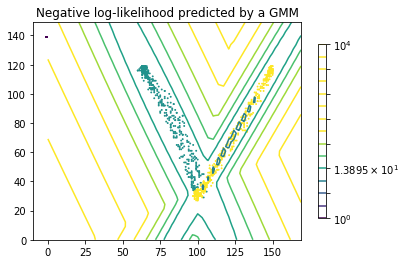

In [73]:
trials = 3 # tests
k_temp = 3

for k in range(trials):
    # fit new GMM
    gmm_temp_A = mixture.GaussianMixture(n_components=k_temp).fit(data_A)
    labels_temp_A = gmm_temp_A.predict(data_A)
    # plot
    plot_data_A(data_A, labels_temp_A, gmm_temp_A)

### 1.1.2 (3.) To validate the assumption of bivariate Gaussian mixture:

#### 1) Plot each marginal histogram (in $x$ and $y$) and add the estimated mixture of univariateGaussian pdfs to the figure.

#### $x$ margin

For this we plot each cluster in a histogram and calculate the pdf using a Gaussian distribution.

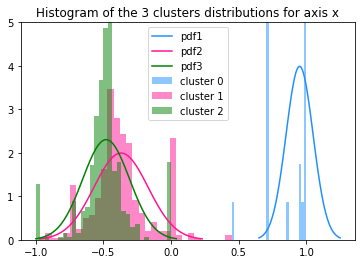

In [32]:
# histograms + pdf
for label in range(k):
    plt.hist(x[labels == label], label = 'cluster ' + str(label), **kwargs, color=col[label])
    pdf_x(gmm, label = label, color = col[label])

# configurations
plot_config_all('x')
plt.show()

#### $y$ margin

We do the exact same thing for the $y$ axis and see that the clusters vary quite a bit. They are separated more clearly than on the x axis! However we also see that outliers pull the curves down and make them broader when the actual cluster is quite dense.

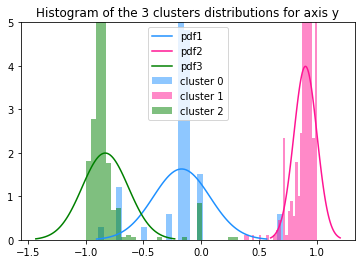

In [33]:
# histograms + pdf
for label in range(k):
    plt.hist(y[labels == label], label = 'cluster ' + str(label), **kwargs, color=col[label])
    pdf_y(gmm, label = label, color = col[label])

# configurations
plot_config_all('y')
plt.show()

#### 2) For each marginal (in $x$ and $y$) provide separate histograms of each cluster and add the estimated univariate Gaussian pdf to the figure.

#### $x$ margin / cluster $1,2,3$

For the first cluster (or other depending on the gmm above) we can see that the curve does not really fit at all due to outlier and a lower density than in the other clusters.

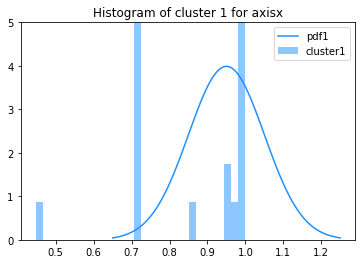

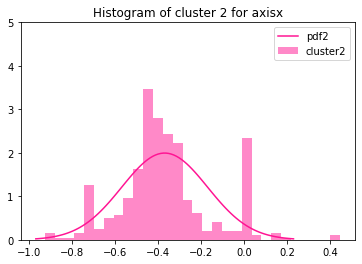

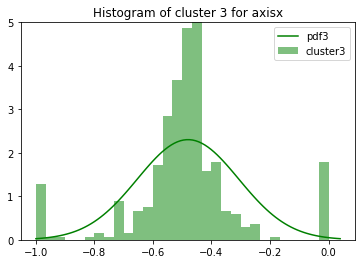

In [34]:
# plot histogram + pdf
for label in range(k):
    plot_single(label,'x')
    
plt.show()

#### $y$ margin / cluster $1,2,3$

For the second cluster (or other depending on the gmm) we can see that the symmetric Gaussian curve does not really fit, we would need a longer left tail.

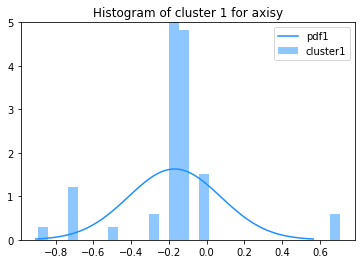

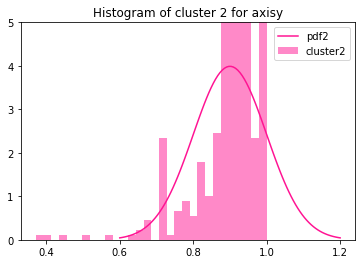

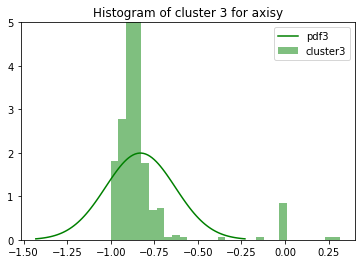

In [35]:
# plot histogram + pdf
for label in range(k):
    plot_single(label,'y')

### 1.1.2 (4.) Comment the results of questions 3 (a) and (b). What do you think about the (bivariate) Gaussianmixture assumption? Why?

The bivariate Gaussian assumption does not quite that accurately reflect the data since the clusters are not symmetric. We would need a different distribution. Also some outliers pull the variance up when the clusters are quite close to the mean.

### 1.1.2 (5.) Plot each data point $x_i$ with some colourmap corresponding to $P(Z_i= 1\vert X_i)$ (you may plot $logP(Z_i= 1\vert X_i)$ instead). How to interpret that plot?

Let us first extract the parameters:

In [36]:
# parameters
weights = gmm.weights_
means = gmm.means_
cov = gmm.covariances_

The following function calculates the probability that a point is in a cluster. Here cluster is a variable. The plots are drawn for all clusters. 

In [46]:
# helper function get p_Z
def get_p_Z(data,weights,mean,variance,cluster):
    total = 0
    for clusters in range(len(weights)):
            total += weights[clusters] * multi.pdf(data, mean[clusters], variance[clusters])
                                            
    p_Z = weights[cluster] * multi.pdf(data, mean[cluster], variance[cluster]) / total
                                          
    return p_Z

We will now highlight every cluster in the plot. The colormap corresponds to the probability $P(Z_i = c\vert X_i)$, where $c$ denotes the current cluster:

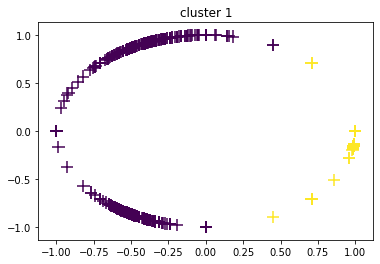

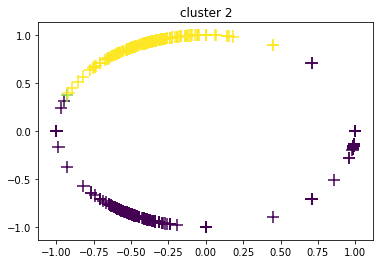

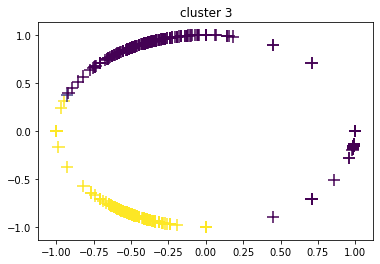

In [38]:
for cluster in range(k):
    
    # probability of cluster
    p_Z = get_p_Z(data,weights,means,cov,cluster)
    
    # plot
    plt.scatter(x, y, marker='+', s=150, linewidths=4, c = p_Z)
    plt.title('cluster ' + str(cluster + 1))
    plt.show()

We can do the same thing for the $A$ sets:

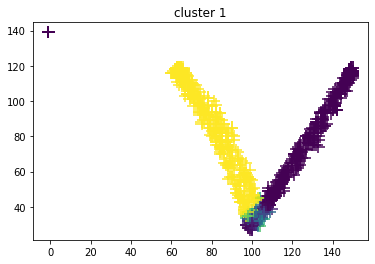

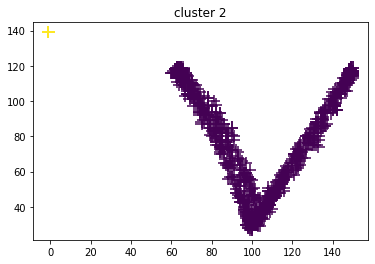

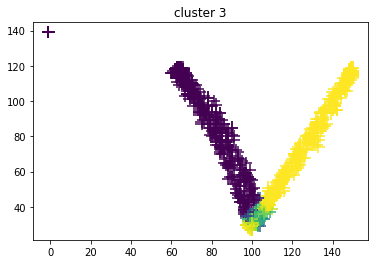

In [43]:
# parameters
weights_A = gmm_A.weights_
means_A = gmm_A.means_
cov_A = gmm_A.covariances_

# data


# plot
for cluster in range(k):
    # probability of cluster
    p_Z = get_p_Z(data_A,weights_A,means_A,cov_A,cluster)
    plt.scatter(x_A, y_A, marker='+', s=150, linewidths=4, c = p_Z)
    plt.title('cluster ' + str(cluster + 1))
    plt.show()

This is not very surprising. For this data set three clusters are not too optimal since the one outlier is seen as an own cluster. We see nicely, however, that the points at the bottom of the V are mixed.

## 1.2 Mandatory Additional Questions: 
The aim of this part is to compare mixture of von Mises distributions with Gaussian mixtures.

### 1.2 (1.) Transform the Unistroke data to angular data. Plot the histogram of angles and comment.

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


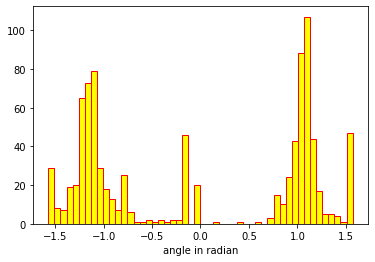

In [39]:
angular = np.arctan(y/x)

plt.hist(angular, bins = 50, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('angle in radian')

plt.show()

Again we can do the same thing for the $A$ set:

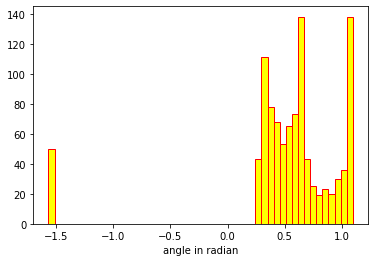

In [44]:
angular_A = np.arctan(y_A/x_A)

plt.hist(angular_A, bins = 50, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('angle in radian')

plt.show()

$\textit{Explanation:}$ We have one outlier (left side) and the rest is on the right. We cannot see different clusters, because both are in the same direction! So this graphic is of no use to differentiate between them. 

We first fit the von Mises pdf:

In [40]:
# fit pdf
p=mixture_vonmises_pdfit(angular,k)

Setting/Initialising some parameters:

In [ ]:
# parameters
kappa = [0] * k
mean = [0] * k
X = np.linspace(-2, 2, 100)
names = ['pdf', 'normalised pdf']

We now plot the histogram and the pdf curves. In the second plot the curves are weighted s.t. their integral will be $1$. 

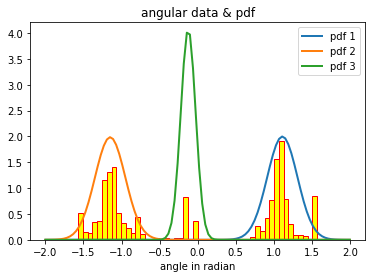

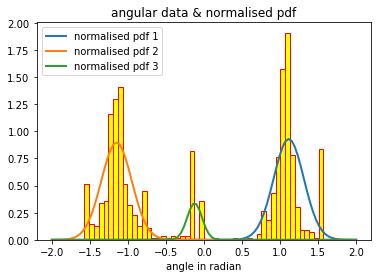

In [41]:
# plot curves
for j in range(2):    
    # plot histogram
    plt.hist(angular, density=True, bins = 50, color = 'yellow', edgecolor = 'red')
    plt.title('angular data & ' + names[j])
    
    for i in range(k):
        # weights
        w = 1*((j+1)%2) + (j%2)*p[0,i]
        kappa[i] = p[2,i]
        mean[i]  = p[1,i]
        
        rv = stats.vonmises(kappa[i], loc = mean[i])
        plt.plot(X, rv.pdf(X) * w, lw = 2, label = names[j] + ' ' + str(i + 1))
        
    plt.xlabel('angle in radian')
    plt.legend()
    plt.show()

Let's do the same for the $A$ set and see where the curves lie:

In [ ]:
# fit pdf
p_A = mixture_vonmises_pdfit(angular_A,k)

# parameters
kappa_A = [0] * k
mean_A = [0] * k
X = np.linspace(-2, 2, 100)
names = ['pdf', 'normalised pdf']

In [1]:
# plot curves
for j in range(2):    
    # plot histogram
    plt.hist(angular_A, density=True, bins = 50, color = 'yellow', edgecolor = 'red')
    plt.title('angular data & ' + names[j])
    
    for i in range(k):
        # weights
        w = 1*((j+1)%2) + (j%2)*p_A[0,i]
        kappa_A[i] = p_A[2,i]
        mean_A[i]  = p_A[1,i]
        
        rv = stats.vonmises(kappa_A[i], loc = mean_A[i])
        plt.plot(X, rv.pdf(X) * w, lw = 2, label = names[j] + ' ' + str(i + 1))
        
    plt.xlabel('angle in radian')
    plt.legend()
    plt.show()

NameError: name 'plt' is not defined

We somehow don't get curves here... TODO

### 1.2 (2.) Define von Mises and mixtures of von Mises distributions.

The von Mises distribution, or the circular normal is defined as:

$V(\theta | \theta_0, m) = \frac{1}{2\pi I_0(m)}e^{m\: cos(\theta - \theta_0)}$ 

with

$0 \leq \theta < 2 \pi, \; m \geq 0, \; 0 \leq \theta_0 < 2 \pi$

where $I_0$ in the normalization factor is the modified zero-order Bessel function of the first kind, and expressed as:

$I_0(m) = \frac{1}{2\pi} \int_0^{2\pi}exp \{m\: cos(\theta)\} \; d\theta$

or 

$I_0(m) = \sum_{r=0}^\infty \frac{1}{r!^2}(\frac{m}{2})^{2r}$.

The mean direction is specified by the $\theta_0$ parameter. The parameter $m$ influences how concentrated the distribution is around the mean direction. Larger values of $m$ result in the distribution being more tightly clustered about the mean direction, and von Mises distribution increasingly resembles the Gaussian with variance 1/$m$.  For $m$ = 0 the distribution collapses in a uniform distribution.

Mixtures of von Mises distributions:

$MovM(\theta| \boldsymbol{\theta_0, m}) = \sum_{k=1}^K \pi_kV(\theta | \theta_{0,k},m_k)$

where $K$ is the number of mixture’s components and $\pi_k$ the weight of the $k$th component.

### 1.2 (3.) A priori, would a mixture of von Mises distributions be more or less adequate than Gaussian mixtures on the real data set of part 1.1? Why?

A mixture of von Mises distributions is more adequate than Gaussian mixtures, because angles are periodic variables and distributed on the boundary of a circle. To model circular data problems the bivariate von Mises is typically used. Using the Gaussian mixtures would be less adequate because the results would depend on the arbitrary choice of the origin, while von Mises distribution is independent of the origin.

### 1.2 (4.) Provide equations for the E-step and M-step of the EM algorithm for mixtures of von Misesdistributions. Justify these results with formal computations.

1) $\textit{Expectation step}$

Given the set $\boldsymbol{\theta}$ = \{$\theta_1, ... , \theta_n$\} of i.i.d. observations and the set of corresponding latent points $\boldsymbol{Z}$ (introduced with a 1-of-K variable $z_i$), we can write the likelihood of the complete data set \{$\boldsymbol{\theta, Z}$\} for the Mixture of von Mises as follows:


\begin{align*}
p(\boldsymbol{\theta, Z | \pi, \theta_0, m}) = \prod_{i=1}^n \prod_{k=1}^K \pi_k^{Z_{ik}} V (\theta_i|\theta_{0,k}, m_k)^{z_{ik}}
\end{align*}

where $z_{ik}$ denotes the $k$th component of $z_i$ and the set of parameters to be estimated through EM is \{$\boldsymbol{\pi,\theta_0,m}$\}, where $\boldsymbol{\pi}$ represents the weights, $\boldsymbol{\theta}$ the mean values, and $\boldsymbol{m}$ the precisions of the mixture’s components. Thus, the expected value of the log likelihood for the complete data set $\mathbb{E}_Z \equiv \mathbb{E}_Z [ln \, p(\boldsymbol{\theta, Z | \pi, \theta_0, m})]$ results to be:

\begin{align*}
\mathbb{E}_Z & = \sum_{i=1}^n \sum_{k=1}^K \gamma_{ik} \{ln \, \pi_k + ln \, V (\theta_i | \theta_{0,k}, m_k)\}\\
& = \sum_{i=1}^n \sum_{k=1}^K \gamma_{ik} \{ln \, \pi_k - ln \, 2\pi I_0(m_k) + m_k \, cos(\theta_i - \theta_{0,k})
\end{align*}

where $\gamma_{ik} \equiv \mathbb{E}[z_{ik}]$ is the responsibility of component $k$ for data point $\theta_i$, and can be estimated using the parameter values of the previous iteration (randomly initialized for the first iteration) as follows:

\begin{align*}
\gamma_{ik} = \frac{\pi_k \, V(\theta_i | \theta_{0,k}, m_k)}{\sum_{s=1}^K \pi_s \, V(\theta_i | \theta_{0,s}, m_s)}
\end{align*}

2) $\textit{Maximization step}$

The M step maximizes the log likelihood of $\mathbb{E}_Z$ with respect to each of the parameters \{$\boldsymbol{\pi, \theta_0, m}$\}. Computing the derivative of $\mathbb{E}_Z$ with respect to $\pi_k$ by making use of a Lagrange multiplier, we can simply obtain:

\begin{align*}
\pi = \frac{1}{n} \sum_{i=1}^n \gamma_{ik}
\end{align*}

Deriving $\mathbb{E}_Z$ on $\theta_{0,k}$ and setting the result equal to zero, leads to the following equation:

\begin{align*}
\sum_{i=1}^n \gamma_{ik} m_k \, \sin{(\theta_i - \theta_{0,k})} = 0,
\end{align*}

which can lead to:

\begin{align*}
\theta_{0,k} = \arctan \left( \frac{\sum_{i=1}^n \gamma_{ik} \sin{\theta_i} }{ \sum_{i=1}^n \gamma_{ik} \cos{\theta_i} } \right)
\end{align*}

Maximization with respect to $m_k$ is not trivial due to the presence of the Bessel function

\begin{align*}
\frac{\partial \mathbb{E}_Z}{\partial m_k} = \frac{I_1 (m_k)}{I_0 (m_k)} \sum_{i=1}^n \gamma_{ik} + \sum_{i=1}^n \gamma_{ik} \, \cos{(\theta_i - \theta_{0,k})} = 0
\end{align*}

This equation can be solved in $m_k$ by introducing a function $A(m_k) = \frac{I_1 (m_k)}{I_0 (m_k)}$ and obtaining:

\begin{align*}
A(m_k) = \left( \frac{\sum_{i=1}^n \gamma_{ik} \cos{(\theta_i - \theta_{0,k})} }{ \sum_{i=1}^n \gamma_{ik}} \right)
\end{align*}

The right side of the equation can be evaluated and then the value of $m_k$ can be computed by inverting the function numerically.

3) $\textit{Iterate procedure}$

Steps 1 and 2 are iterated until convergence (reached when the likelihood does not change too much between two consecutive iterations) or until a given number of iterations is reached.

$\textbf{References}$
1. CALDERARA et al. "MIXTURES OF VON MISES DISTRIBUTIONS FOR PEOPLE TRAJECTORY SHAPE ANALYSIS" p. 457, p. 459 eq 1, eq 3, p. 460, p. 468 \newline
2. John Bentley "MODELLING CIRCULAR DATA USING A MIXTURE OF VON MISES AND UNIFORM DISTRIBUTIONS" p. iii, p. 1, p. 4  \newline
3. R. M. Lark et al. "Modelling complex geological circular data with the projected normal distribution and mixtures of von Mises distributions" p.631 \newline
4. Qifeng Jiang "ON FITTING A MIXTURE OF TWO VON MISES DISTRIBUTIONS, WITH APPLICATIONS" p. 1, p. 3 \newline
5. Bishop, "Pattern Recognition and Machine Learning" p. 108, equation 2.179 and p. 693 \newline
6. Parthan Kasarapu "Mixtures of Bivariate von Mises Distributions with Applications to Modelling of Protein Dihedral Angles" p. 1, p. 2